In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [2]:
movies = pd.read_csv("mymoviedb.csv", lineterminator="\n")
movies.drop(movies[movies["Vote_Count"] == 0].index,
            inplace=True)  # usun filmy z przyszlosci
movies.drop(["Overview", "Popularity", "Vote_Count",
            "Poster_Url"], axis=1, inplace=True)

X = movies.drop("Vote_Average", axis=1)
y = movies["Vote_Average"]


In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)
kFold = KFold(n_splits=5)


In [4]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


In [5]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


In [6]:
from sklearn.preprocessing import OneHotEncoder

simple_cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Original_Language"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

simple_cat_pipeline.fit_transform(X_train)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
from datetime import datetime


class DateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols = []
        for col_name in X.columns:
            cols.append(X[col_name].map(
                lambda x: datetime.strptime(x, "%Y-%m-%d").year))
            cols.append(X[col_name].map(
                lambda x: datetime.strptime(x, "%Y-%m-%d").month))
        return np.c_[cols].T


In [8]:
date_pipeline = Pipeline([
    ("select_date", DataFrameSelector(["Release_Date"])),
    ("imputer", MostFrequentImputer()),
    ("date_encoder", DateEncoder()),
])

date_pipeline.fit_transform(X_train)


array([[2015,    1],
       [2005,    9],
       [1992,    4],
       ...,
       [1983,    7],
       [2015,    7],
       [2007,    3]], dtype=int64)

In [9]:
class GenreEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, delimeter=","):
        self.genres = {}
        for col in X.columns:
            self.genres[col] = set()
            for index, row in X.iterrows():
                self.genres[col] |= set(
                    map(lambda x: x.strip(), row[col].split(delimeter)))
        return self

    def transform(self, X, y=None):
        encoded = []
        for col, curr_genres in self.genres.items():
            for genre in curr_genres:
                encoded.append(X[col].str.contains(genre).astype(int))
        return np.c_[encoded].T


In [10]:
genre_pipeline = Pipeline([
    ("select_genre", DataFrameSelector(["Genre"])),
    ("imputer", MostFrequentImputer()),
    ("genre_encoder", GenreEncoder()),
])

genre_pipeline.fit_transform(X_train)


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 1, 0, 0]])

In [11]:
import re


class TitleEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.genres = {}
        return self

    def transform(self, X, y=None):
        encoded = []
        for col in X.columns:
            encoded.append(X["Title"].map(lambda x: bool(
                re.search(r'\d', x))).astype(int))  # cyfry w tytule
            # ilosc slow w tytule
            encoded.append(X["Title"].map(lambda x: len(x.split())))
            encoded.append(X["Title"].str.contains(
                ":").astype(int))  # dwukropek w tytule
            encoded.append(X["Title"].str.contains(
                "-").astype(int))  # pauza w tytule

        return np.c_[encoded].T


In [12]:
title_pipeline = Pipeline([
    ("select_title", DataFrameSelector(["Title"])),
    ("imputer", MostFrequentImputer()),
    ("title_encoder", TitleEncoder()),
])

title_pipeline.fit_transform(X_train)


array([[0, 2, 0, 0],
       [0, 4, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 3, 0, 0],
       [0, 5, 1, 0],
       [0, 5, 1, 0]], dtype=int64)

In [13]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("simple_cat_pipeline", simple_cat_pipeline),
    ("date_pipeline", date_pipeline),
    ("genre_pipeline", genre_pipeline),
    ("title_pipeline", title_pipeline),
])


In [14]:
preprocess_pipeline.transform(X_train).shape


(8754, 66)

**MODELE**

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


1. ElasticNet

In [16]:
from sklearn.linear_model import ElasticNet

ElasticNet_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", ElasticNet())
])

ElasticNet_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

grid_1 = GridSearchCV(estimator=ElasticNet_pipeline,
                      param_grid=ElasticNet_param_grid, scoring="r2", cv=kFold)
grid_1.fit(X_train, y_train)
grid_1.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.065e+01, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.988e-01, tolerance: 6.053e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

{'regressor__alpha': 0.001, 'scaler': None}

2. SVR RBF

In [26]:
from sklearn.svm import SVR

SVR_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", StandardScaler()),
    ("regressor", SVR(kernel="rbf"))
])

SVR_param_grid = {
    "regressor__C": [0.01, 0.1, 1, 10, 100, 1000],
    "regressor__gamma": [0.001, 0.01, 0.1, 1],
}

grid_2 = GridSearchCV(estimator=SVR_pipeline,
                      param_grid=SVR_param_grid, scoring="r2", cv=kFold)
grid_2.fit(X_train, y_train)
grid_2.best_params_


{'regressor__C': 1, 'regressor__gamma': 0.01}

3. Drzewo decyzyjne

In [18]:
from sklearn.tree import DecisionTreeRegressor

DecisionTree_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", DecisionTreeRegressor())
])

DecisionTree_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__max_depth": [None, 1, 2, 3, 4, 5],
    "regressor__max_features": [None, "auto", "sqrt", "log2"],
    "regressor__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
}

grid_3 = GridSearchCV(estimator=DecisionTree_pipeline,
                      param_grid=DecisionTree_param_grid, scoring="r2", cv=kFold)
grid_3.fit(X_train, y_train)
grid_3.best_params_


{'regressor__criterion': 'friedman_mse',
 'regressor__max_depth': 5,
 'regressor__max_features': None,
 'scaler': MinMaxScaler()}

4. Liniowy SVR

In [20]:
from sklearn.svm import LinearSVR

LinearSVR_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", LinearSVR())
])

LinearSVR_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

grid_4 = GridSearchCV(estimator=LinearSVR_pipeline,
                      param_grid=LinearSVR_param_grid, scoring="r2", cv=kFold)
grid_4.fit(X_train, y_train)
grid_4.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.w

{'regressor__C': 0.1, 'scaler': MinMaxScaler()}

5. Regresja Lasso

In [24]:
from sklearn.linear_model import Lasso

Lasso_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", Lasso())
])

Lasso_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
}

grid_5 = GridSearchCV(estimator=Lasso_pipeline,
                      param_grid=Lasso_param_grid, scoring="r2", cv=kFold)
grid_5.fit(X_train, y_train)
grid_5.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+01, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e+02, tolerance: 6.025e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

{'regressor__alpha': 0.001, 'scaler': None}

**Porównanie płytkich modeli**

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, max_error

models = []

models.append(("ElasticNet", grid_1.best_score_, grid_1.best_estimator_))
models.append(("SVR", grid_2.best_score_, grid_2.best_estimator_))
models.append(("Decision Tree", grid_3.best_score_, grid_3.best_estimator_))
models.append(("Linear SVR", grid_4.best_score_, grid_4.best_estimator_))
models.append(("Lasso", grid_5.best_score_, grid_5.best_estimator_))

names = []
scores_train = []
scores_test_r2 = []
scores_test_mse = []
scores_test_me = []

for name, train_score, estimator in models:
    names.append(name)
    scores_train.append(train_score)

    r2_test_score = r2_score(y_test, estimator.predict(X_test))
    scores_test_r2.append(r2_test_score)

    mse_test_score = mean_squared_error(y_test, estimator.predict(X_test))
    scores_test_mse.append(mse_test_score)

    me_test_score = max_error(y_test, estimator.predict(X_test))
    scores_test_me.append(me_test_score)


model_data = {
    "model name": names,
    "training score (r2)": scores_train,
    "test score (r2)": scores_test_r2,
    "test score (mean squared error)": scores_test_mse,
    "test score (max error)": scores_test_me
}
table = pd.DataFrame(model_data)
table


,model name,training score (r2),test score (r2),test score (mean squared error),test score (max error)
0,ElasticNet,0.197765,0.206276,0.659564,4.374816
1,SVR,0.229291,0.245390,0.627062,4.841273
2,Decision Tree,0.177988,0.174545,0.685932,4.215801
3,Linear SVR,0.190244,0.197078,0.667208,4.436693
4,Lasso,0.197216,0.204051,0.661413,4.375000


**Modele głębokie**

In [16]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [17]:
X_train_preprocessed = preprocess_pipeline.transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_preprocessed)

X_train_keras = scaler.transform(X_train_preprocessed)
X_test_keras = scaler.transform(X_test_preprocessed)

print(X_train_keras.shape)
print(X_test_keras.shape)


(8754, 66)
(973, 66)


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

from keras.callbacks import History

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [39]:
from keras import backend as K


def keras_r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [34]:
def build_model(n_hidden=1, n_neurons=30, activation="relu", learning_rate=3e-3, input_shape=[66,]):
    model = keras.models.Sequential()

    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
    
    model.add(keras.layers.Dense(1, activation="relu"))
    # optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer="Adam", metrics=[keras_r2])

    return model

In [35]:
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

C:\Users\Admin\AppData\Local\Temp\ipykernel_13176\3463659828.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)


1. Karas Randomized Search CV (liczba warstw + liczba neuronów)

In [50]:
param_distribs_1 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
}

rnd_search_cv_1 = RandomizedSearchCV(keras_class, param_distribs_1, n_iter=10, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_1.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])
rnd_search_cv_1.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
176/176 [==============================] - 1s 4ms/step - loss: 1576.7817 - keras_r2: -21.2653 - val_loss: 1056.6931 - val_keras_r2: -13.0870
Epoch 2/100
176/176 [==============================] - 1s 3ms/step - loss: 446.9236 - keras_r2: -6.6031 - val_loss: 143.4822 - val_keras_r2: -0.8035
Epoch 3/100
176/176 [==============================] - 1s 4ms/step - loss: 116.8785 - keras_r2: -1.4209 - val_loss: 107.9671 - val_keras_r2: -0.3156
Epoch 4/100
176/176 [==============================] - 1s 3ms/step - loss: 96.8893 - keras_r2: -0.3854 - val_loss: 99.3815 - val_keras_r2: -0.1977
Epoch 5/100
176/176 [==============================] - 0s 3ms/step - loss: 88.5856 - keras_r2: -0.1137 - val_loss: 95.1601 - val_keras_r2: -0.1397
Epoch 6/100
176/176 [==============================] - 1s 3ms/step - loss: 83.1728 - keras_r2: -0.0463 - val_loss: 92.9270 - val_keras_r2: -0.1104
Epoch 7/100
176/176 [==========================

: 

: 

In [44]:
history = History()

model_1 = Sequential()
model_1.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_1.add(Dense(89,activation="relu"))
model_1.add(Dense(89,activation="relu"))
model_1.add(Dense(1,activation="relu"))
model_1.summary()

model_1.compile(loss="mean_squared_error",optimizer="Adam", metrics=[keras_r2])

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 89)                5963      
                                                                 
 dense_175 (Dense)           (None, 89)                8010      
                                                                 
 dense_176 (Dense)           (None, 1)                 90        
                                                                 
Total params: 14,063
Trainable params: 14,063
Non-trainable params: 0
_________________________________________________________________


In [46]:
history_1 = model_1.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[early_stopping])

Epoch 1/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6448 - keras_r2: 0.2101 - val_loss: 0.6556 - val_keras_r2: 0.1717
Epoch 2/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6465 - keras_r2: 0.2172 - val_loss: 0.6985 - val_keras_r2: 0.0974
Epoch 3/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6534 - keras_r2: 0.2130 - val_loss: 0.7119 - val_keras_r2: 0.0870
Epoch 4/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6220 - keras_r2: 0.2380 - val_loss: 0.6926 - val_keras_r2: 0.1165
Epoch 5/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6158 - keras_r2: 0.2458 - val_loss: 0.7264 - val_keras_r2: 0.0737
Epoch 6/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6178 - keras_r2: 0.2584 - val_loss: 0.6536 - val_keras_r2: 0.1641
Epoch 7/100
274/274 [==============================] - 1s 3ms/step - loss: 0.6108 - keras_r2: 0.2580 - val_loss: 0.6748 - val_keras_r2: 0.1307

In [47]:
model_1.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.7012 - keras_r2: 0.0858


[0.7012064456939697, 0.08582678437232971]

In [48]:
history_1.history.keys()

dict_keys(['loss', 'keras_r2', 'val_loss', 'val_keras_r2'])

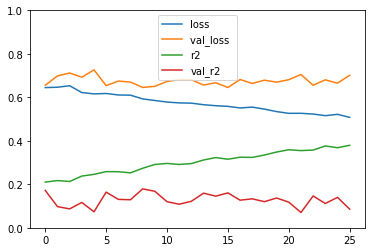

In [49]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_1.history['loss'], label="loss")
plt.plot(history_1.history['val_loss'], label="val_loss ")

plt.plot(history_1.history['keras_r2'], label="r2")
plt.plot(history_1.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()